In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [36]:
# batch size / parallel random contexts
batch_size = 32

# block size / length of context
block_size = 8

max_iter = 10000
eval_iter = 200

eval_interval = 300
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

n_embed = 65
n_head = 6
n_layer = 6
dropout = 0.2


In [4]:
torch.manual_seed(22)

In [5]:
with open("input.txt", 'r') as f:
    text = f.read()

In [6]:
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [7]:
# take out unique characters and make encoder and decoder functions
vocab = set(text)
decoded = {i : x for i,x in enumerate(vocab)}
encoded = {x : i for i,x in enumerate(vocab)}

encoder = lambda text : [encoded[x] for x in text]
decoder = lambda text : ''.join([decoded[x] for x in text])
print(vocab, "\n", encoded, "\n", decoded)

{'d', 'Y', 'e', 'c', 'W', 'l', '-', 'T', '&', ';', 'z', 'N', 'R', '3', 'F', '?', 'w', 'j', 't', 'K', 's', ' ', 'g', '!', 'U', '$', 'k', 'E', 'x', 'G', 'A', 'H', 'y', 'I', 'L', 'S', 'M', 'o', 'h', 'V', 'X', 'i', 'P', 'J', 'f', 'b', 'C', '.', '\n', 'v', 'O', 'm', 'Z', ':', 'u', 'Q', 'B', 'r', 'a', ',', 'n', 'D', 'q', 'p', "'"} 
 {'d': 0, 'Y': 1, 'e': 2, 'c': 3, 'W': 4, 'l': 5, '-': 6, 'T': 7, '&': 8, ';': 9, 'z': 10, 'N': 11, 'R': 12, '3': 13, 'F': 14, '?': 15, 'w': 16, 'j': 17, 't': 18, 'K': 19, 's': 20, ' ': 21, 'g': 22, '!': 23, 'U': 24, '$': 25, 'k': 26, 'E': 27, 'x': 28, 'G': 29, 'A': 30, 'H': 31, 'y': 32, 'I': 33, 'L': 34, 'S': 35, 'M': 36, 'o': 37, 'h': 38, 'V': 39, 'X': 40, 'i': 41, 'P': 42, 'J': 43, 'f': 44, 'b': 45, 'C': 46, '.': 47, '\n': 48, 'v': 49, 'O': 50, 'm': 51, 'Z': 52, ':': 53, 'u': 54, 'Q': 55, 'B': 56, 'r': 57, 'a': 58, ',': 59, 'n': 60, 'D': 61, 'q': 62, 'p': 63, "'": 64} 
 {0: 'd', 1: 'Y', 2: 'e', 3: 'c', 4: 'W', 5: 'l', 6: '-', 7: 'T', 8: '&', 9: ';', 10: 'z', 11

In [37]:
vocab_size = len(vocab)
data = torch.tensor(encoder(text))
n = int(len(data) * 0.85)

trainX = data[:n]
testX = data[n:]

In [38]:
def get_batch(x):
    data = trainX if x == 'train' else testX
    # get random contexts starting index for given batch size parallel processing
    idx = torch.randint(len(data) - block_size, (batch_size,))

    rcx = torch.stack([data[i: i + block_size] for i in idx])
    rcy = torch.stack([data[i+1 : i + block_size + 1] for i in idx])
    
    return rcx, rcy

In [39]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iter)
        for x in range(eval_iter):
            X, y = get_batch(split)
            logits, loss = model(X, y)
            losses[x] = loss.item()
            
        out[split] = losses.mean()
    model.train()
    return out

In [40]:
class Head(nn.Module):
    # one head of self attention
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias = False)
        self.query = nn.Linear(n_embed, head_size, bias = False)
        self.value = nn.Linear(n_embed, head_size, bias = False)
        #  if i write triangle  in register buffer instead of tril i can write self.triangle in forward later
        # The register_buffer function in PyTorch lets you name and store tensors that should be saved with the
        # model but don't need gradients for training
        # like a constant tensor
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        
        # bring out embeddings for related X 
        # embedding are like encodings and are only used to fetch encoded values and not any calculation
        k = self.key(x) # B, T, hs
        q = self.query(x) # B, T, hs
        v = self.value(x) # B, T, hs       
        
        # get attention scores
        scores = q @ k.transpose(-2, -1) * k.shape[-1] ** (-0.5)
        scores = scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        scores = F.softmax(scores, dim = -1)
        scores = self.dropout(scores)
        
        scores = scores @ v
        
        return scores


### The formula used in scores var in fwd function of single head
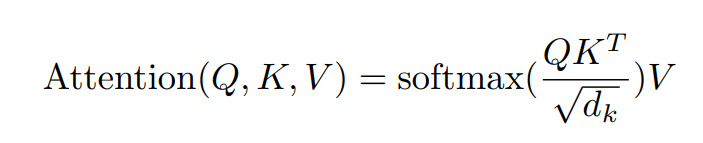

In [56]:
k = torch.tril(torch.ones(block_size, block_size))
#g = nn.Module.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
k.masked_fill(k[:10, :10] == 0, float('-inf'))

tensor([[1., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., -inf, -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., -inf, -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., -inf, -inf, -inf, -inf],
        [1., 1., 1., 1., 1., -inf, -inf, -inf],
        [1., 1., 1., 1., 1., 1., -inf, -inf],
        [1., 1., 1., 1., 1., 1., 1., -inf],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [41]:
class MultiHeadAttention(nn.Module):
    # multiple self attention heads
    
    def __init__(self, n_head, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)]) 
        self.proj = nn.Linear(head_size * n_head, n_embed)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))
        return out
    
    

In [42]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(

                nn.Linear(n_embed, 4 * n_embed),
                nn.ReLU(), 
                nn.Linear(4 * n_embed, n_embed),
                nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

In [43]:
class Block(nn.Module):
    # transformer bloack : communication followed by computatiojmn
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)     
    
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [44]:
class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean = 0, std = 0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0, std = 0.02) 
            
    def forward(self, idx, targets = None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) #T, C
        
        x = token_emb + pos_emb # b,t,c
        x = self.blocks(x) #btc
        x = self.ln_f(x) #btc
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is B, T array of indices in current context
        
        for _ in range(max_new_tokens):
            idx_ = idx[:, -block_size:]
            logits, loss = self(idx_)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
            idx = torch.cat((idx, idx_next), dim = 1)
            
        return idx

In [45]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.309465 M parameters


In [46]:
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

for iters in range(max_iter):
    
    if iters % 100 == 0:
        losses = estimate_loss()
        print(f"step {iters}: train loss {losses['train']:.4f}, val loss {losses['test']:.4f}")
        
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
    

step <built-in function iter>: train loss 4.1749, val loss 4.1777
step <built-in function iter>: train loss 2.7071, val loss 2.7129
step <built-in function iter>: train loss 2.5132, val loss 2.5086
step <built-in function iter>: train loss 2.4535, val loss 2.4648
step <built-in function iter>: train loss 2.4018, val loss 2.3887
step <built-in function iter>: train loss 2.3459, val loss 2.3438
step <built-in function iter>: train loss 2.3259, val loss 2.3464
step <built-in function iter>: train loss 2.2912, val loss 2.3053
step <built-in function iter>: train loss 2.2664, val loss 2.2835
step <built-in function iter>: train loss 2.2424, val loss 2.2637
step <built-in function iter>: train loss 2.2382, val loss 2.2774
step <built-in function iter>: train loss 2.2115, val loss 2.2262
step <built-in function iter>: train loss 2.2134, val loss 2.2303
step <built-in function iter>: train loss 2.1678, val loss 2.2037
step <built-in function iter>: train loss 2.1726, val loss 2.1969
step <buil


KeyboardInterrupt



In [48]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decoder(m.generate(context, max_new_tokens=500)[0].tolist()))

d.

Cits somer word, be boy be; nenterseatt.

RICIUSSTATK:
And haved youid' way fut is beforther.

DUEENG RIGARCAMLA:
Way priendest the the 'to gorinlen stice untelin bareist his as to me;
And The with:
My andidy shohwandlard ranged of for well'll surplier:
As Browns
Are onthenwith there warl's by enead to ficchnirst unhered,
Whe le were, to muse Hows to--

Let:

Sare If hom thank he howger fore to thest from to tolo mave my nother, his to
pay bence as forthy have you, but laonds, day unfrom thim
